# Ban Luck - Using Reinforcement Learning to Squeeze your Relatives Dry

## What is Ban Luck?
In Southeast Asia (SEA), a Chinese New Year (CNY) tradition is to play Chinese Blackjack (Ban Luck) as a social activity. 

The game is as follows:

![How to Play?](assets/how_to_play.png "How to Play?")

But, you want to "huat" (Be prosperous), so how do you squeeze every penny out of your relatives?

**So, how do we play Ban Luck optimally?**

## A typical strategy

### The Algorithm
As a player, what would be your strategy? Personally, I follow this algorithm:
```
Loop until Hold or Reveal:
  Let value = Hand value
  if value == 21 or value >= 17:
    Hold
  else:
    Draw
  if hand has 5 cards:
    Reveal
```

As a dealer, I would follow a similar algorithm but instead of holding, I would reveal hands.

Feels simple, and based on vibes, it seems sound!

### Benchmarking
But let's simulate some games with this algorithm and see how well it actually performs. 

For simplicity, 
- Everyone uses this algorithm in any given game unless otherwise stated.
- For all our runs unless otherwise stated, we will stick to 8 players (Including dealer).
- Be realistic, you will play at most 30 games every CNY. Despite that, our future measurements will be based on 1,000 games.

In [1]:
from players import SimplePlayer
from dealer import SimpleDealer
from game import Game, make_deck
from simulation import run_game
import numpy as np
import matplotlib.pyplot as plt
from deck import WashShuffleStrategy

N_PLAYERS = 8 # Includes dealer
SIMULATIONS = 1_000
# Exclude dealer
game = Game(n_players=N_PLAYERS - 1)

# rewards[i, j] is the reward for the j-th player in the i-th simulation
rewards = np.zeros((SIMULATIONS, N_PLAYERS))

deck = make_deck()
shuffle = WashShuffleStrategy()
for i in range(SIMULATIONS):
    shuffle.shuffle(deck) # Random shuffle
    # Simple is the strategy name for the algorithm we just described
    res = run_game(game, SimplePlayer(), SimpleDealer(), deck=deck)
    for j in range(N_PLAYERS):
        rewards[i, j] = res[j]
    game.soft_reset()

# Boxplot to show rewards for all players including dealer
COLOR_POSITIVE = "#00c950"
COLOR_NEGATIVE = "#fb2c36"
LABELS = "#e5e7eb"
BORDER = "#90a1b9"
BG = "#1d293d"

data_by_player = [rewards[:, j] for j in range(N_PLAYERS)]
medians = np.median(rewards, axis=0)
box_colors = [COLOR_POSITIVE if m >= 0 else COLOR_NEGATIVE for m in medians]

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor(BG)
fig.patch.set_facecolor(BG)
bp = ax.boxplot(data_by_player, positions=range(N_PLAYERS), patch_artist=True)
for patch, color in zip(bp["boxes"], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(BORDER)
    patch.set_alpha(0.8)
for item in bp["fliers"]:
    item.set_color(BORDER)
    item.set_markerfacecolor(BORDER)
    item.set_markeredgecolor(BORDER)
for el in ["whiskers", "caps"]:
    for item in bp[el]:
        item.set_color(BORDER)
for item in bp["medians"]:
    item.set_color(LABELS)

ax.set_xticks(range(N_PLAYERS))
ax.set_xticklabels(["Dealer"] + [str(i) for i in range(1, N_PLAYERS)], color=LABELS)
ax.set_xlabel("Player", color=LABELS)
ax.set_ylabel("Reward", color=LABELS)
ax.set_title("Reward distribution by player (all players including dealer)", color=LABELS)
ax.tick_params(colors=LABELS)
ax.spines[:].set_color(LABELS)
plt.show()


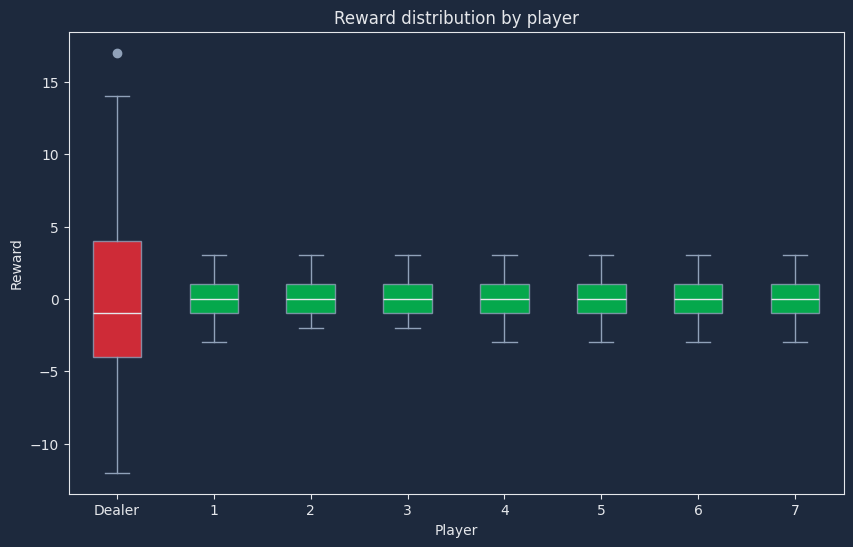

In [2]:
# Box plot: reward distribution for each player
COLOR_POSITIVE = "#00c950"
COLOR_NEGATIVE = "#fb2c36"
COLOR_PRIMARY = "#00bcff"
COLOR_SECONDARY = "#fe9a00"
BG = "#1d293d"
LABELS = "#e5e7eb"
BORDER = "#90a1b9"

# One column per player: rewards[:, j] = all simulation rewards for player j
data_by_player = [rewards[:, j] for j in range(N_PLAYERS)]
medians = np.median(rewards, axis=0)
box_colors = [COLOR_POSITIVE if m >= 0 else COLOR_NEGATIVE for m in medians]

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor(BG)
fig.patch.set_facecolor(BG)
bp = ax.boxplot(data_by_player, positions=range(N_PLAYERS), patch_artist=True)
for patch, color in zip(bp["boxes"], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(BORDER)
    patch.set_alpha(0.8)
for item in bp["fliers"]:
    item.set_color(BORDER)
    item.set_markerfacecolor(BORDER)
    item.set_markeredgecolor(BORDER)
for el in ["whiskers", "caps"]:
    for item in bp[el]:
        item.set_color(BORDER)
for item in bp["medians"]:
    item.set_color(LABELS)

ax.set_xticks(range(N_PLAYERS))
ax.set_xticklabels(["Dealer"] + [str(i) for i in range(1, N_PLAYERS)], color=LABELS)
ax.set_xlabel("Player", color=LABELS)
ax.set_ylabel("Reward", color=LABELS)
ax.set_title("Reward distribution by player", color=LABELS)
ax.tick_params(colors=LABELS)
ax.spines[:].set_color(LABELS)
plt.show()

Some observations:
- Position of the players (Excluding dealer) does not seem to matter
- Dealer seems to perform worse than players

But is that the case?

## Analyzing Typical Algorithm

### Does Position Matter?
**TL;DR** There is no statistically detectable difference in rewards between seats. 

In [3]:
import pandas as pd
from statsmodels.stats.anova import AnovaRM

# We will only analyze players (Excluding dealer)
data_by_player = [rewards[:, j] for j in range(1, N_PLAYERS)]
rows = []
for run in range(rewards.shape[0]):
    for player in range(1, N_PLAYERS):
        rows.append({"run": run, "player": player, "reward": rewards[run, player]})
df = pd.DataFrame(rows)

model = AnovaRM(data=df, depvar="reward", subject="run", within=["player"])
result = model.fit()
print("One-way repeated measures ANOVA: reward ~ player (subject = run)")
print(result.anova_table)

One-way repeated measures ANOVA: reward ~ player (subject = run)
         F Value  Num DF  Den DF    Pr > F
player  0.170131     6.0  5994.0  0.984802


Think of the `F Value` as how much `variability between rows (across players) / variability between columns (within a player) = 0.5578`, that is less variability between players than within players. There's a `76.4643%` chance of seeing this randomness purely by chance.

### Does being the Dealer matter?

**TL;DR** There is no signficant evidence to show that being the dealer is inherently disadvantageous. 

In [4]:
# Consolidate mean across all rows in data_by_player (one value per run for players)
# Compare with dealer's mean using paired t test
import numpy as np
from scipy import stats

dealer_rewards = rewards[:, 0]  # shape (SIMULATIONS,)
# Per run: mean reward of all non-dealer players (so we have one value per run to pair with dealer)
players_mean_per_run = np.mean(rewards[:, 1:], axis=1)  # shape (SIMULATIONS,)
t_stat, p_value = stats.ttest_rel(players_mean_per_run, dealer_rewards)
print("Paired t-test (dealer vs mean-of-players per run):")
print(f"  t = {t_stat:.4f}, p = {p_value:.4f}")
print(f"  Dealer mean = {np.mean(dealer_rewards):.4f}, Players (consolidated) mean = {np.mean(players_mean_per_run):.4f}")


Paired t-test (dealer vs mean-of-players per run):
  t = -0.3148, p = 0.7530
  Dealer mean = 0.0550, Players (consolidated) mean = -0.0079



## Deck Shuffling

Before finding our optimal strategy, let's step back and think about our environment. I theorise that **how we shuffle our deck influences our strategy due to predictability**.

The deck is initially sorted (Ace, 2, 3, ..., J, Q, K), we want to reduce *predictability* of cards so we first have to shuffle the deck.

Before playing, the deck goes through a **Wash Shuffle**. Cards scatter on the floor and scrambled.

![Wash Shuffle](assets/wash_shuffle.png "Wash Shuffle")

But this is very tedious to do and not everyone has card shuffling skills to **Riffle SHuffle** (Cards can also get damaged).

Instead, in subsequent games, the deck goes through a series of **Cut Shuffles**.

![Cut Shuffle](assets/cut_shuffle.png "Cut Shuffle")

Instinctively, how we shuffle the deck should influence our strategy. If we do simple deck cutting, it feels that **we can predict where cards are, based on previous game localities due to ordering. This predictability can be learnt throughout the game**.

![Predictability Problem](assets/predictability_problem.png "Predictability Problem")

For instance, if we draw an Ace, **there is a high chance the next card is also an ace**, the cards local to it is what we can predict.

When we say a deck is *Predicatable*, the deck has long strateches of *Localities* where we can guess. One metric to measure these *localities* is by looking at the *Longest Increasing Subsequence (LIS)*.

Let's use LIS to compare both **Wash Shuffle** and **Deck Cutting**.

For simplicity, let's:
- Approximate a **Wash Shuffle** as a `random.shuffle` in Python.
- Assume `30 to 70%` each cut.
- Assume a **Wash Shuffle** is the "most random" strategy we can use when shuffling our deck 

In [5]:
import bisect
import numpy as np
import matplotlib.pyplot as plt
from game import make_deck
from deck import WashShuffleStrategy, DeckCuttingStrategy

N_SHUFFLES = 1_000
N_TO_TEST = 500

base_deck = make_deck()
card_to_index = {card: i for i, card in enumerate(base_deck)}

def deck_to_permutation(deck, card_to_index=card_to_index):
    return [card_to_index[c] for c in deck]

def lis_length(perm):
    tails = []
    for x in perm:
        i = bisect.bisect_left(tails, x)
        if i == len(tails):
            tails.append(x)
        else:
            tails[i] = x
    return len(tails)

wash = WashShuffleStrategy()
results = {}

vals = []
for _ in range(N_SHUFFLES):
    deck = make_deck()
    wash.shuffle(deck)
    vals.append(lis_length(deck_to_permutation(deck)))

results["Wash"] = vals

for n_cuts in range(1, N_TO_TEST + 1):
    strategy = DeckCuttingStrategy(
        n=n_cuts,
        deck_interleaving_probability=0
    )

    vals = []
    for _ in range(N_SHUFFLES):
        deck = make_deck()
        strategy.shuffle(deck)
        vals.append(lis_length(deck_to_permutation(deck)))

    results[f"Cut n={n_cuts}"] = vals


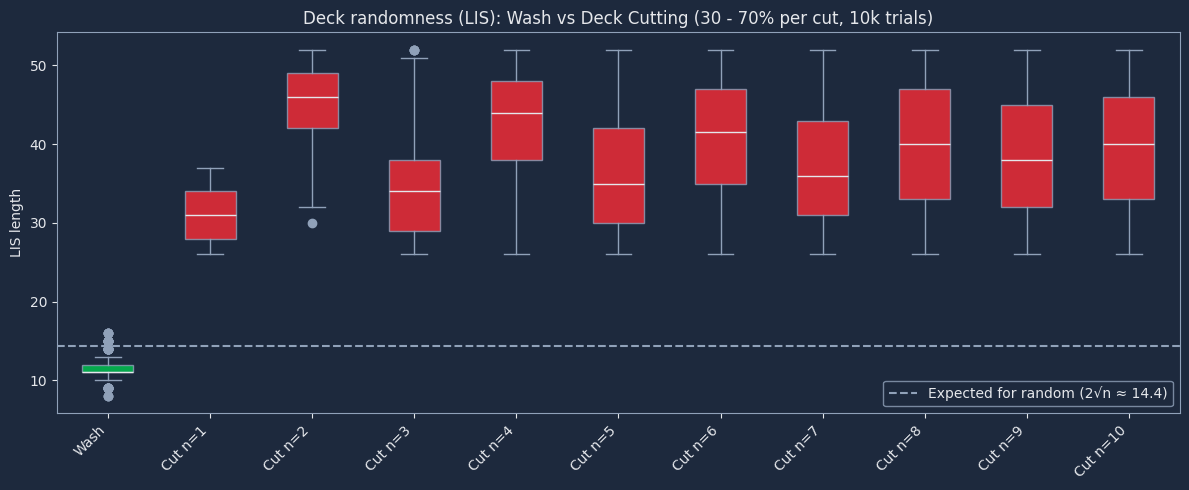

In [6]:
# Just plot the first 10
N_TO_PLOT = 10
labels = ["Wash"] + [f"Cut n={k}" for k in range(1, N_TO_PLOT + 1)]
data_by_strategy = [results[label] for label in labels]
medians = [np.median(results[label]) for label in labels]
# Green = more random (LIS closer to 2√n ≈ 14.4), red = more ordered
expected_random_lis = 2 * (52 ** 0.5)
# Green if LIS is close to 2√n ≈ 14.4, red if LIS is close to 1
box_colors = [COLOR_POSITIVE if m <= expected_random_lis else COLOR_NEGATIVE for m in medians]

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_facecolor(BG)
fig.patch.set_facecolor(BG)

bp = ax.boxplot(data_by_strategy, positions=np.arange(len(labels)), patch_artist=True)
for patch, color in zip(bp["boxes"], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(BORDER)
    patch.set_alpha(0.8)
for item in bp["fliers"]:
    item.set_color(BORDER)
    item.set_markerfacecolor(BORDER)
    item.set_markeredgecolor(BORDER)
for el in ["whiskers", "caps"]:
    for item in bp[el]:
        item.set_color(BORDER)
for item in bp["medians"]:
    item.set_color(LABELS)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right", color=LABELS)
ax.axhline(y=expected_random_lis, color=BORDER, linestyle="--", label=f"Expected for random (2√n ≈ {expected_random_lis:.1f})")
ax.set_ylabel("LIS length", color=LABELS)
ax.set_title("Deck randomness (LIS): Wash vs Deck Cutting (30 - 70% per cut, 10k trials)", color=LABELS)
ax.legend(facecolor=BG, edgecolor=BORDER, labelcolor=LABELS)
ax.tick_params(colors=LABELS)
ax.spines[:].set_color(BORDER)
plt.tight_layout()
plt.show()

Some observations:
- There is a difference between **Wash Shuffle** and **Deck Cutting Shuffle**.
- Increasing the number of deck cuts, `n`, seems to converge.

Let's zoom out. If we plot the mean of deck cutting for each n, we see that it plateus.

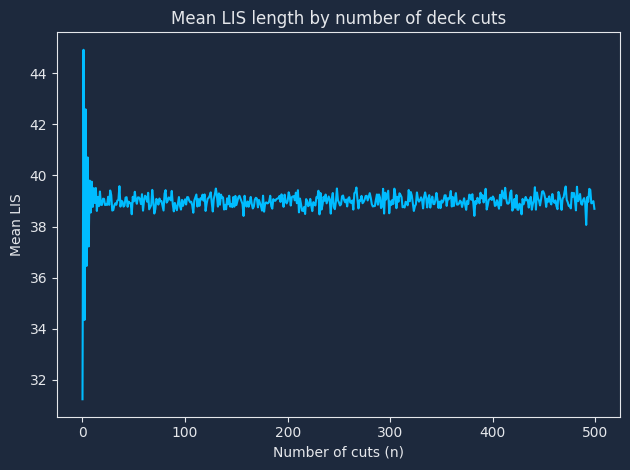

In [7]:
N_TO_PLOT = N_TO_TEST
labels = [f"Cut n={k}" for k in range(1, N_TO_PLOT + 1)]
data_by_strategy = [results[label] for label in labels]
medians = [np.mean(results[label]) for label in labels]

fig, ax = plt.subplots()
ax.set_facecolor(BG)
fig.patch.set_facecolor(BG)
ax.plot(medians, color=COLOR_PRIMARY)
ax.set_title("Mean LIS length by number of deck cuts", color=LABELS)
ax.set_xlabel("Number of cuts (n)", color=LABELS)
ax.set_ylabel("Mean LIS", color=LABELS)
ax.tick_params(colors=LABELS)
ax.spines[:].set_color(LABELS)
plt.tight_layout()
plt.show()


We see that it converges to `~39`. This is due to the cyclical nature of deck cut shuffles, you are only shifting the bottom portion to the top.
Think: `1 2 3 4 5 6 7 8` cut to `7 8 1 2 3 4 5 6` cut to `3 4 5 6 7 8 1 2`. Notice the relative order does not change, there are only `52 permutaitons`.

Realistically, there are some variations with where you put the cut, it may fall between some top part of the deck.

![Cut Interleave Shuffle](assets/cut_interleave_shuffle.png "Cut Interleave Shuffle")

In theory, this should break this cycle. Let's assume you do it every 1 in 3 shuffles.

In [8]:
results = {}
for n_cuts in range(1, N_TO_TEST + 1):
    strategy = DeckCuttingStrategy(
        n=n_cuts,
        deck_interleaving_probability=1/3
    )

    vals = []
    for _ in range(N_SHUFFLES):
        deck = make_deck()
        strategy.shuffle(deck)
        vals.append(lis_length(deck_to_permutation(deck)))

    results[f"Cut n={n_cuts}"] = vals

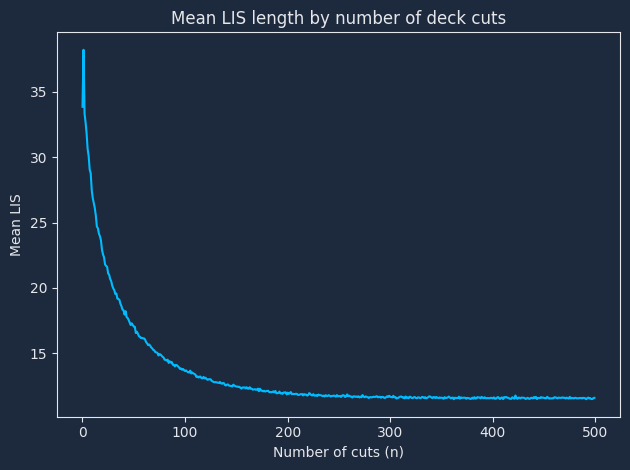

In [9]:
N_TO_PLOT = N_TO_TEST
labels = [f"Cut n={k}" for k in range(1, N_TO_PLOT + 1)]
data_by_strategy = [results[label] for label in labels]
medians = [np.mean(results[label]) for label in labels]

fig, ax = plt.subplots()
ax.set_facecolor(BG)
fig.patch.set_facecolor(BG)
ax.plot(medians, color=COLOR_PRIMARY)
ax.set_title("Mean LIS length by number of deck cuts", color=LABELS)
ax.set_xlabel("Number of cuts (n)", color=LABELS)
ax.set_ylabel("Mean LIS", color=LABELS)
ax.tick_params(colors=LABELS)
ax.spines[:].set_color(LABELS)
plt.tight_layout()
plt.show()

Just by doing this 1 simple change, it converges to what seems like **Wash Shuffle** (Not going to prove it). 

But notice, earlier on there is still a high level of *Predictability*. Realistically, for each game, you shuffle `~8` times (Based on observations). During CNY, you will probably play `~10-20` games in one seating. **The point being, having a high level of predictability early on may have an impact on how you play**. 

Furthermore, this is all relative to a sorted deck. **From game to game, you will still have a high level of predictability**.

## Finding Optimal Strategy (Policy) with Reinforcement Learning (RL)

### The Idea
One way to find the optimal strategy is by using Reinforcement Learning (RL).

There are too many variables to consider when deciding whether to draw or hold a card. It depends on:
- How many cards were already drawn before you
- What is your current hand value 
- How many cards you have on your hand

This is very annoying to model manually. Instead, let's do the fun thing, simulating many games (Monte Carlo Control) to find our strategy!

Here's the high level idea:
```
Initialise current strategy = Random Strategy (E.g. use trivial strategy)
Run the game many times (1,000,000):
    Play the game. When it's your turn,
        For each action,
            Small probability of taking another action, to explore other possibilities.
            Else, refer to the current strategy, safe choice!
        When rewarded:
            Update strategy based on the average reward of using this strategy.
    Else, when it is the other player's turn or the dealer's turn:
        Use the typical strategy.
```
Every unique hand is a State. For every state, we evaluate our possible Actions (Draw/Reveal or Hold). By averaging the rewards of these actions over millions of rounds, the "optimal" move for every possible hand emerges.

### Wash Shuffle Every Game
Let's assume we do a **Wash Shuffle** after each game. How will this strategy fare compared to the typical strategy?

In [10]:
from agent import mc_control, policy_to_dict
import json

num_episodes = 1_000_000
epsilon = 0.1

print("Training Player agent (Monte Carlo control)...")
print(f"  n_players={N_PLAYERS}, agent_position=1, num_episodes={num_episodes}, epsilon={epsilon}")
Q, policy = mc_control(
    n_players=N_PLAYERS,
    agent_position=1,
    num_episodes=num_episodes,
    epsilon=epsilon,
    first_shuffle_strategy=WashShuffleStrategy(),
    subsequent_shuffle_strategy=WashShuffleStrategy(),
)

policy_path = "all_wash_shuffle_8p_policy.json"
policy = dict(sorted(policy.items(), key=lambda x: (len(x[0]), x[0])))
data = policy_to_dict(policy)
with open(policy_path, "w") as f:
    json.dump(data, f, indent=2)

Training Player agent (Monte Carlo control)...
  n_players=8, agent_position=1, num_episodes=1000000, epsilon=0.1
Episode 0 of 1000000 (0.0%)
Episode 100000 of 1000000 (10.0%)
Episode 200000 of 1000000 (20.0%)
Episode 300000 of 1000000 (30.0%)
Episode 400000 of 1000000 (40.0%)
Episode 500000 of 1000000 (50.0%)
Episode 600000 of 1000000 (60.0%)
Episode 700000 of 1000000 (70.0%)
Episode 800000 of 1000000 (80.0%)
Episode 900000 of 1000000 (90.0%)


**If only you use this strategy**

In [17]:
from pathlib import Path
import json
from players import PolicyBasedPlayer
from agent import policy_from_dict
from deck import WashShuffleStrategy, DeckCuttingStrategy

BENCHMARK_RUNS = 10_000
policy_path = Path("all_wash_shuffle_8p_policy.json")
if not policy_path.exists():
    raise FileNotFoundError(f"Policy not found: {policy_path}. Run the training cell above first.")

with open(policy_path) as f:
    policy = policy_from_dict(json.load(f))

policy_player = PolicyBasedPlayer(policy, epsilon=0.0)
simple_player = SimplePlayer()
dealer = SimpleDealer()
bench_game = Game(n_players=N_PLAYERS - 1)
wash_shuffle = WashShuffleStrategy()
deck_cutting = DeckCuttingStrategy()
deck = make_deck()

rewards_policy_runs = np.zeros(BENCHMARK_RUNS)
rewards_simple_runs = np.zeros(BENCHMARK_RUNS)

cur_deck = deck.copy()
wash_shuffle.shuffle(cur_deck)
for run in range(BENCHMARK_RUNS):
    res_p = run_game(bench_game, [
        policy_player,
        simple_player,
        simple_player,
        simple_player,
        simple_player,
        simple_player,
        simple_player,
    ], dealer, cur_deck)
    rewards_policy_runs[run] = np.mean(res_p[1:])
    bench_game.soft_reset()
    deck_cutting.shuffle(cur_deck)

cur_deck = deck.copy()
wash_shuffle.shuffle(cur_deck)
for run in range(BENCHMARK_RUNS):
    res_s = run_game(bench_game, simple_player, dealer, cur_deck)
    rewards_simple_runs[run] = np.mean(res_s[1:])
    bench_game.soft_reset()
    deck_cutting.shuffle(cur_deck)

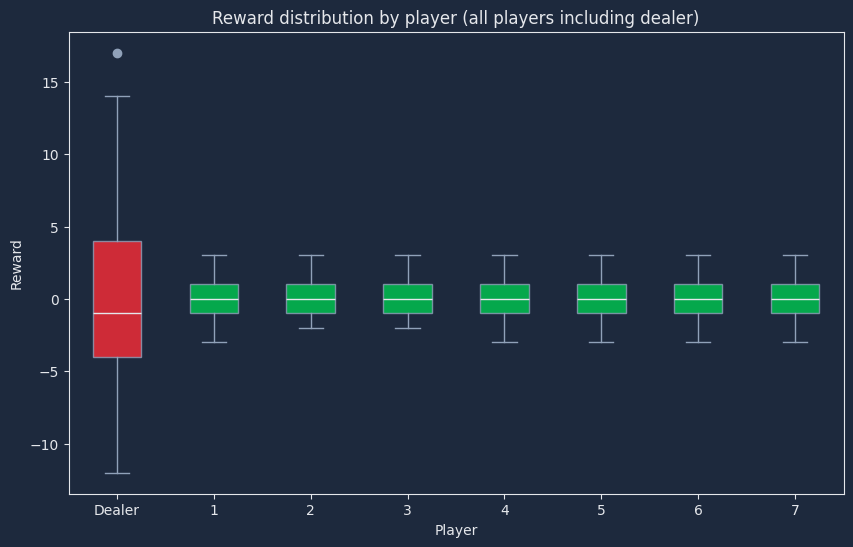

In [ ]:
data_by_player = [rewards[:, j] for j in range(N_PLAYERS)]
medians = np.median(rewards, axis=0)
box_colors = [COLOR_POSITIVE if m >= 0 else COLOR_NEGATIVE for m in medians]

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor(BG)
fig.patch.set_facecolor(BG)
bp = ax.boxplot(data_by_player, positions=range(N_PLAYERS), patch_artist=True)
for patch, color in zip(bp["boxes"], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(BORDER)
    patch.set_alpha(0.8)
for item in bp["fliers"]:
    item.set_color(BORDER)
    item.set_markerfacecolor(BORDER)
    item.set_markeredgecolor(BORDER)
for el in ["whiskers", "caps"]:
    for item in bp[el]:
        item.set_color(BORDER)
for item in bp["medians"]:
    item.set_color(LABELS)

ax.set_xticks(range(N_PLAYERS))
ax.set_xticklabels(["Dealer"] + [str(i) for i in range(1, N_PLAYERS)], color=LABELS)
ax.set_xlabel("Player", color=LABELS)
ax.set_ylabel("Reward", color=LABELS)
ax.set_title("Reward distribution by player (all players including dealer)", color=LABELS)
ax.tick_params(colors=LABELS)
ax.spines[:].set_color(LABELS)
plt.show()

Benchmark: 10000 games, 8 players (including dealer)

PolicyBasedPlayer (trained):
  Mean reward (per player): 0.0552
  Std dev:                  0.7773

SimplePlayer:
  Mean reward (per player): 0.0408
  Std dev:                  0.7956

Comparison
  Mean difference (Policy - Simple): 0.0144
  95% CI: [-0.0075, 0.0363]
  Paired t-test: t = 1.2864, p = 0.1983


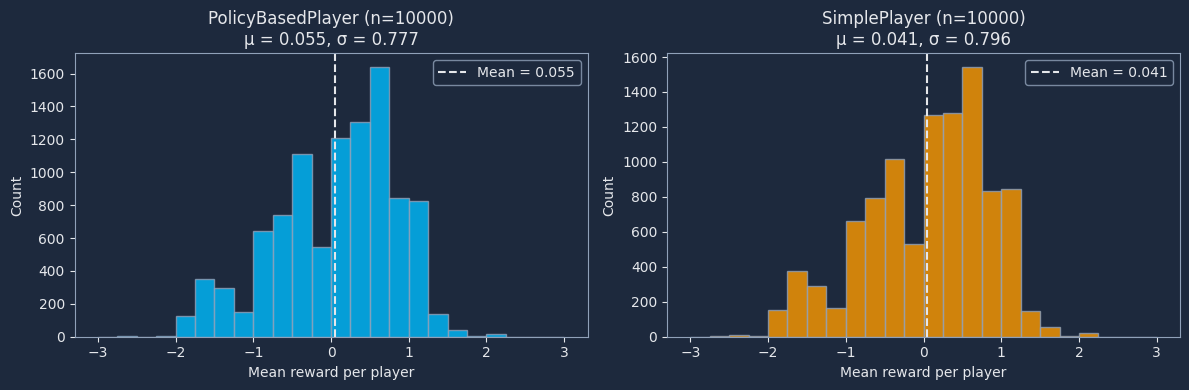

In [19]:
mean_policy = np.mean(rewards_policy_runs)
mean_simple = np.mean(rewards_simple_runs)
std_policy = np.std(rewards_policy_runs, ddof=1)
std_simple = np.std(rewards_simple_runs, ddof=1)

print(f"Benchmark: {BENCHMARK_RUNS} games, {N_PLAYERS} players (including dealer)\n")
print("PolicyBasedPlayer (trained):")
print(f"  Mean reward (per player): {mean_policy:.4f}")
print(f"  Std dev:                  {std_policy:.4f}")
print("\nSimplePlayer:")
print(f"  Mean reward (per player): {mean_simple:.4f}")
print(f"  Std dev:                  {std_simple:.4f}")

mean_diff = mean_policy - mean_simple
if BENCHMARK_RUNS >= 2:
    t_stat, p_value = stats.ttest_rel(rewards_policy_runs, rewards_simple_runs)
    diffs = rewards_policy_runs - rewards_simple_runs
    std_diff = np.std(diffs, ddof=1)
    se_diff = std_diff / np.sqrt(BENCHMARK_RUNS)
    t_95 = 1.96 if BENCHMARK_RUNS > 30 else {2: 4.30, 5: 2.57, 10: 2.23, 20: 2.09, 30: 2.04}.get(BENCHMARK_RUNS, 2.0)
    ci_lo, ci_hi = mean_diff - t_95 * se_diff, mean_diff + t_95 * se_diff
    print()
    print("Comparison")
    print(f"  Mean difference (Policy - Simple): {mean_diff:.4f}")
    print(f"  95% CI: [{ci_lo:.4f}, {ci_hi:.4f}]")
    print(f"  Paired t-test: t = {t_stat:.4f}, p = {p_value:.4f}")

# Histograms for both strategies (reuse COLOR_*, BG, LABELS, BORDER from cells above)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.patch.set_facecolor(BG)
bin_edges = np.arange(-3, 3.25, 0.25)
axes[0].set_facecolor(BG)
axes[0].hist(rewards_policy_runs, bins=bin_edges, color=COLOR_PRIMARY, edgecolor=BORDER, alpha=0.8)
axes[0].axvline(mean_policy, color=LABELS, linestyle="--", label=f"Mean = {mean_policy:.3f}")
axes[0].set_xlabel("Mean reward per player", color=LABELS)
axes[0].set_ylabel("Count", color=LABELS)
axes[0].set_title(f"PolicyBasedPlayer (n={BENCHMARK_RUNS})\nμ = {mean_policy:.3f}, σ = {std_policy:.3f}", color=LABELS)
axes[0].legend(facecolor=BG, edgecolor=BORDER, labelcolor=LABELS)
axes[0].tick_params(colors=LABELS)
axes[0].spines[:].set_color(BORDER)

axes[1].set_facecolor(BG)
axes[1].hist(rewards_simple_runs, bins=bin_edges, color=COLOR_SECONDARY, edgecolor=BORDER, alpha=0.8)
axes[1].axvline(mean_simple, color=LABELS, linestyle="--", label=f"Mean = {mean_simple:.3f}")
axes[1].set_xlabel("Mean reward per player", color=LABELS)
axes[1].set_ylabel("Count", color=LABELS)
axes[1].set_title(f"SimplePlayer (n={BENCHMARK_RUNS})\nμ = {mean_simple:.3f}, σ = {std_simple:.3f}", color=LABELS)
axes[1].legend(facecolor=BG, edgecolor=BORDER, labelcolor=LABELS)
axes[1].tick_params(colors=LABELS)
axes[1].spines[:].set_color(BORDER)
plt.tight_layout()
plt.show()

Statistically insignificant to make this conclusion.

### Wash Shuffle, then subsequently Deck Cutting (No interleaving)
Let's assume pure deck cutting without interleaving.

In [20]:
num_episodes = 1_000_000
epsilon = 0.1

print("Training Player agent (Monte Carlo control)...")
print(f"  n_players={N_PLAYERS}, agent_position=1, num_episodes={num_episodes}, epsilon={epsilon}")
Q, policy = mc_control(
    n_players=N_PLAYERS,
    agent_position=1,
    num_episodes=num_episodes,
    epsilon=epsilon,
    first_shuffle_strategy=WashShuffleStrategy(),
    subsequent_shuffle_strategy=DeckCuttingStrategy(
        deck_interleaving_probability=0
    ),
)

policy_path = "all_wash_then_cut_shuffle_8p_policy.json"
policy = dict(sorted(policy.items(), key=lambda x: (len(x[0]), x[0])))
data = policy_to_dict(policy)
with open(policy_path, "w") as f:
    json.dump(data, f, indent=2)

Training Player agent (Monte Carlo control)...
  n_players=8, agent_position=1, num_episodes=1000000, epsilon=0.1
Episode 0 of 1000000 (0.0%)
Episode 100000 of 1000000 (10.0%)
Episode 200000 of 1000000 (20.0%)
Episode 300000 of 1000000 (30.0%)
Episode 400000 of 1000000 (40.0%)
Episode 500000 of 1000000 (50.0%)
Episode 600000 of 1000000 (60.0%)
Episode 700000 of 1000000 (70.0%)
Episode 800000 of 1000000 (80.0%)
Episode 900000 of 1000000 (90.0%)


In [21]:
BENCHMARK_RUNS = 10_000
policy_path = Path("all_wash_then_cut_shuffle_8p_policy.json")
if not policy_path.exists():
    raise FileNotFoundError(f"Policy not found: {policy_path}. Run the training cell above first.")

with open(policy_path) as f:
    policy = policy_from_dict(json.load(f))

policy_player = PolicyBasedPlayer(policy, epsilon=0.0)
simple_player = SimplePlayer()
dealer = SimpleDealer()
bench_game = Game(n_players=N_PLAYERS - 1)
wash_shuffle = WashShuffleStrategy()
deck_cutting = DeckCuttingStrategy()
deck = make_deck()

rewards_policy_runs = np.zeros(BENCHMARK_RUNS)
rewards_simple_runs = np.zeros(BENCHMARK_RUNS)

cur_deck = deck.copy()
wash_shuffle.shuffle(cur_deck)
for run in range(BENCHMARK_RUNS):
    res_p = run_game(bench_game, policy_player, dealer, cur_deck)
    rewards_policy_runs[run] = np.mean(res_p[1:])
    bench_game.soft_reset()
    deck_cutting.shuffle(cur_deck)

cur_deck = deck.copy()
wash_shuffle.shuffle(cur_deck)
for run in range(BENCHMARK_RUNS):
    res_s = run_game(bench_game, simple_player, dealer, cur_deck)
    rewards_simple_runs[run] = np.mean(res_s[1:])
    bench_game.soft_reset()
    deck_cutting.shuffle(cur_deck)


In [ ]:
data_by_player = [rewards[:, j] for j in range(N_PLAYERS)]
medians = np.median(rewards, axis=0)
box_colors = [COLOR_POSITIVE if m >= 0 else COLOR_NEGATIVE for m in medians]

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor(BG)
fig.patch.set_facecolor(BG)
bp = ax.boxplot(data_by_player, positions=range(N_PLAYERS), patch_artist=True)
for patch, color in zip(bp["boxes"], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(BORDER)
    patch.set_alpha(0.8)
for item in bp["fliers"]:
    item.set_color(BORDER)
    item.set_markerfacecolor(BORDER)
    item.set_markeredgecolor(BORDER)
for el in ["whiskers", "caps"]:
    for item in bp[el]:
        item.set_color(BORDER)
for item in bp["medians"]:
    item.set_color(LABELS)

ax.set_xticks(range(N_PLAYERS))
ax.set_xticklabels(["Dealer"] + [str(i) for i in range(1, N_PLAYERS)], color=LABELS)
ax.set_xlabel("Player", color=LABELS)
ax.set_ylabel("Reward", color=LABELS)
ax.set_title("Reward distribution by player (all players including dealer)", color=LABELS)
ax.tick_params(colors=LABELS)
ax.spines[:].set_color(LABELS)
plt.show()

In [ ]:
mean_policy = np.mean(rewards_policy_runs)
mean_simple = np.mean(rewards_simple_runs)
std_policy = np.std(rewards_policy_runs, ddof=1)
std_simple = np.std(rewards_simple_runs, ddof=1)

print(f"Benchmark: {BENCHMARK_RUNS} games, {N_PLAYERS} players (including dealer)\n")
print("PolicyBasedPlayer (trained):")
print(f"  Mean reward (per player): {mean_policy:.4f}")
print(f"  Std dev:                  {std_policy:.4f}")
print("\nSimplePlayer:")
print(f"  Mean reward (per player): {mean_simple:.4f}")
print(f"  Std dev:                  {std_simple:.4f}")

mean_diff = mean_policy - mean_simple
if BENCHMARK_RUNS >= 2:
    t_stat, p_value = stats.ttest_rel(rewards_policy_runs, rewards_simple_runs)
    diffs = rewards_policy_runs - rewards_simple_runs
    std_diff = np.std(diffs, ddof=1)
    se_diff = std_diff / np.sqrt(BENCHMARK_RUNS)
    t_95 = 1.96 if BENCHMARK_RUNS > 30 else {2: 4.30, 5: 2.57, 10: 2.23, 20: 2.09, 30: 2.04}.get(BENCHMARK_RUNS, 2.0)
    ci_lo, ci_hi = mean_diff - t_95 * se_diff, mean_diff + t_95 * se_diff
    print()
    print("Comparison")
    print(f"  Mean difference (Policy - Simple): {mean_diff:.4f}")
    print(f"  95% CI: [{ci_lo:.4f}, {ci_hi:.4f}]")
    print(f"  Paired t-test: t = {t_stat:.4f}, p = {p_value:.4f}")

# Histograms for both strategies (reuse COLOR_*, BG, LABELS, BORDER from cells above)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.patch.set_facecolor(BG)
bin_edges = np.arange(-3, 3.25, 0.25)
axes[0].set_facecolor(BG)
axes[0].hist(rewards_policy_runs, bins=bin_edges, color=COLOR_PRIMARY, edgecolor=BORDER, alpha=0.8)
axes[0].axvline(mean_policy, color=LABELS, linestyle="--", label=f"Mean = {mean_policy:.3f}")
axes[0].set_xlabel("Mean reward per player", color=LABELS)
axes[0].set_ylabel("Count", color=LABELS)
axes[0].set_title(f"PolicyBasedPlayer (n={BENCHMARK_RUNS})\nμ = {mean_policy:.3f}, σ = {std_policy:.3f}", color=LABELS)
axes[0].legend(facecolor=BG, edgecolor=BORDER, labelcolor=LABELS)
axes[0].tick_params(colors=LABELS)
axes[0].spines[:].set_color(BORDER)

axes[1].set_facecolor(BG)
axes[1].hist(rewards_simple_runs, bins=bin_edges, color=COLOR_SECONDARY, edgecolor=BORDER, alpha=0.8)
axes[1].axvline(mean_simple, color=LABELS, linestyle="--", label=f"Mean = {mean_simple:.3f}")
axes[1].set_xlabel("Mean reward per player", color=LABELS)
axes[1].set_ylabel("Count", color=LABELS)
axes[1].set_title(f"SimplePlayer (n={BENCHMARK_RUNS})\nμ = {mean_simple:.3f}, σ = {std_simple:.3f}", color=LABELS)
axes[1].legend(facecolor=BG, edgecolor=BORDER, labelcolor=LABELS)
axes[1].tick_params(colors=LABELS)
axes[1].spines[:].set_color(BORDER)
plt.tight_layout()
plt.show()

## Conclusion
So how to huat at ban luck? No real strategy, **JUST BE lUCKY!**.

## The Real Point of this Post
It's about the joy of learning. Building this has uncovered all these theories I had in the back of my mind. Despite not being able to find a better strategy, it was incredibly fun to test all these ideas. That's my phillosophy with building.

We tend to rush into things, use tools for the sake of using them without truly understanding why

Over the past 2 years, I have been approached by 20+ students asking for advice on their projects, **I absolutely love it!**

Often, I get asked **What should I be using?**. This was my mindset, I have worked on over 100+ projects, but not until last year, I did not manage to ship anything. I realised the demotivation stems from not finding the **right meaning** for myself.

In the era of vibe coding, we tend to rush into things without really thinking through what we are doing. I have found a lot of times, I have to rely on my own intuition, and question what is being done. I still needed the domain knowledge 